In [1]:
# Run terminal command to install gcc for surprise package or run the python command below to install.
# import os
# os.system("apt update && apt upgrade && apt install gcc && conda install numpy pandas matplotlib scikit-learn && pip install scikit-surprise merlin-models")

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler as normScaler
from sklearn.preprocessing import MinMaxScaler as uniformScaler
from sklearn.svm import LinearSVR
from sklearn.mixture import BayesianGaussianMixture as GMRec
from surprise import Dataset, SVD, Reader
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

targets = ["PANAS"]
id = 0

def toSurprise(df, target):
    dfTemp = df.copy()
    dfTemp['id'] = df.index
    dfTemp = dfTemp.loc[:, ["id","pPlace",target]] # PANAS
    dfTemp.columns = ["id", "key", "value"]
    return dfTemp

In [2]:
# step 0: fix the random seed for reproductivity
randSeed = 42
np.random.seed(seed=randSeed)

In [8]:
# step 1: import data
np.random.seed(seed=randSeed)
# data = pd.read_csv("./data.csv")
# !!!!! Above is the actual data. Below is the fake data. The current analysis is based on fake data.
fakedata = {"pPlace":np.random.binomial(n=10, p=0.5, size=[113]),
           "PANAS":np.random.normal(loc=0.0, scale=1.0, size=[113]),
            "EmotionalStability":np.random.normal(loc=0.0, scale=1.0, size=[113]),
            "Conscientiousness":np.random.normal(loc=0.0, scale=1.0, size=[113]),
            "Agreeableness":np.random.normal(loc=0.0, scale=1.0, size=[113]),
            "Openness":np.random.normal(loc=0.0, scale=1.0, size=[113]),
            "treatment":np.random.binomial(n=10, p=0.5, size=[113]),
            "Extraversion":np.random.normal(loc=0.0, scale=1.0, size=[113])
            }
fakedata = pd.DataFrame.from_dict(fakedata)
data = fakedata
# Filter out church
# data = data.loc[data["pPlace"] != "church",:]
data['pPlace'] = data['pPlace'].apply(lambda x: "park" if x >=5 else "mall")
print(f"Data.shape: {data.shape}.")
print(f"Data first several lines:\n {data.iloc[:2, :]}")

Data.shape: (113, 8).
Data first several lines:
   pPlace     PANAS  EmotionalStability  Conscientiousness  Agreeableness  \
0   mall  0.501448            0.092479           0.012147      -0.137078   
1   park  1.158187            0.630075           0.930934       0.200134   

   Openness  treatment  Extraversion  
0 -0.148551          9     -0.164536  
1 -0.407460          5      0.186767  


In [9]:
# step 2: shuffle the data
np.random.seed(seed=randSeed)
data = data.sample(frac=1, random_state=randSeed).reset_index(drop=True)

# setp 3: criterion for recommendation
colNames = data.columns.to_list()
print(f"col names: {colNames}")
BF = ['EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'Extraversion']
recCrit_PANAS = ['PANAS'] + BF

col names: ['pPlace', 'PANAS', 'EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'treatment', 'Extraversion']


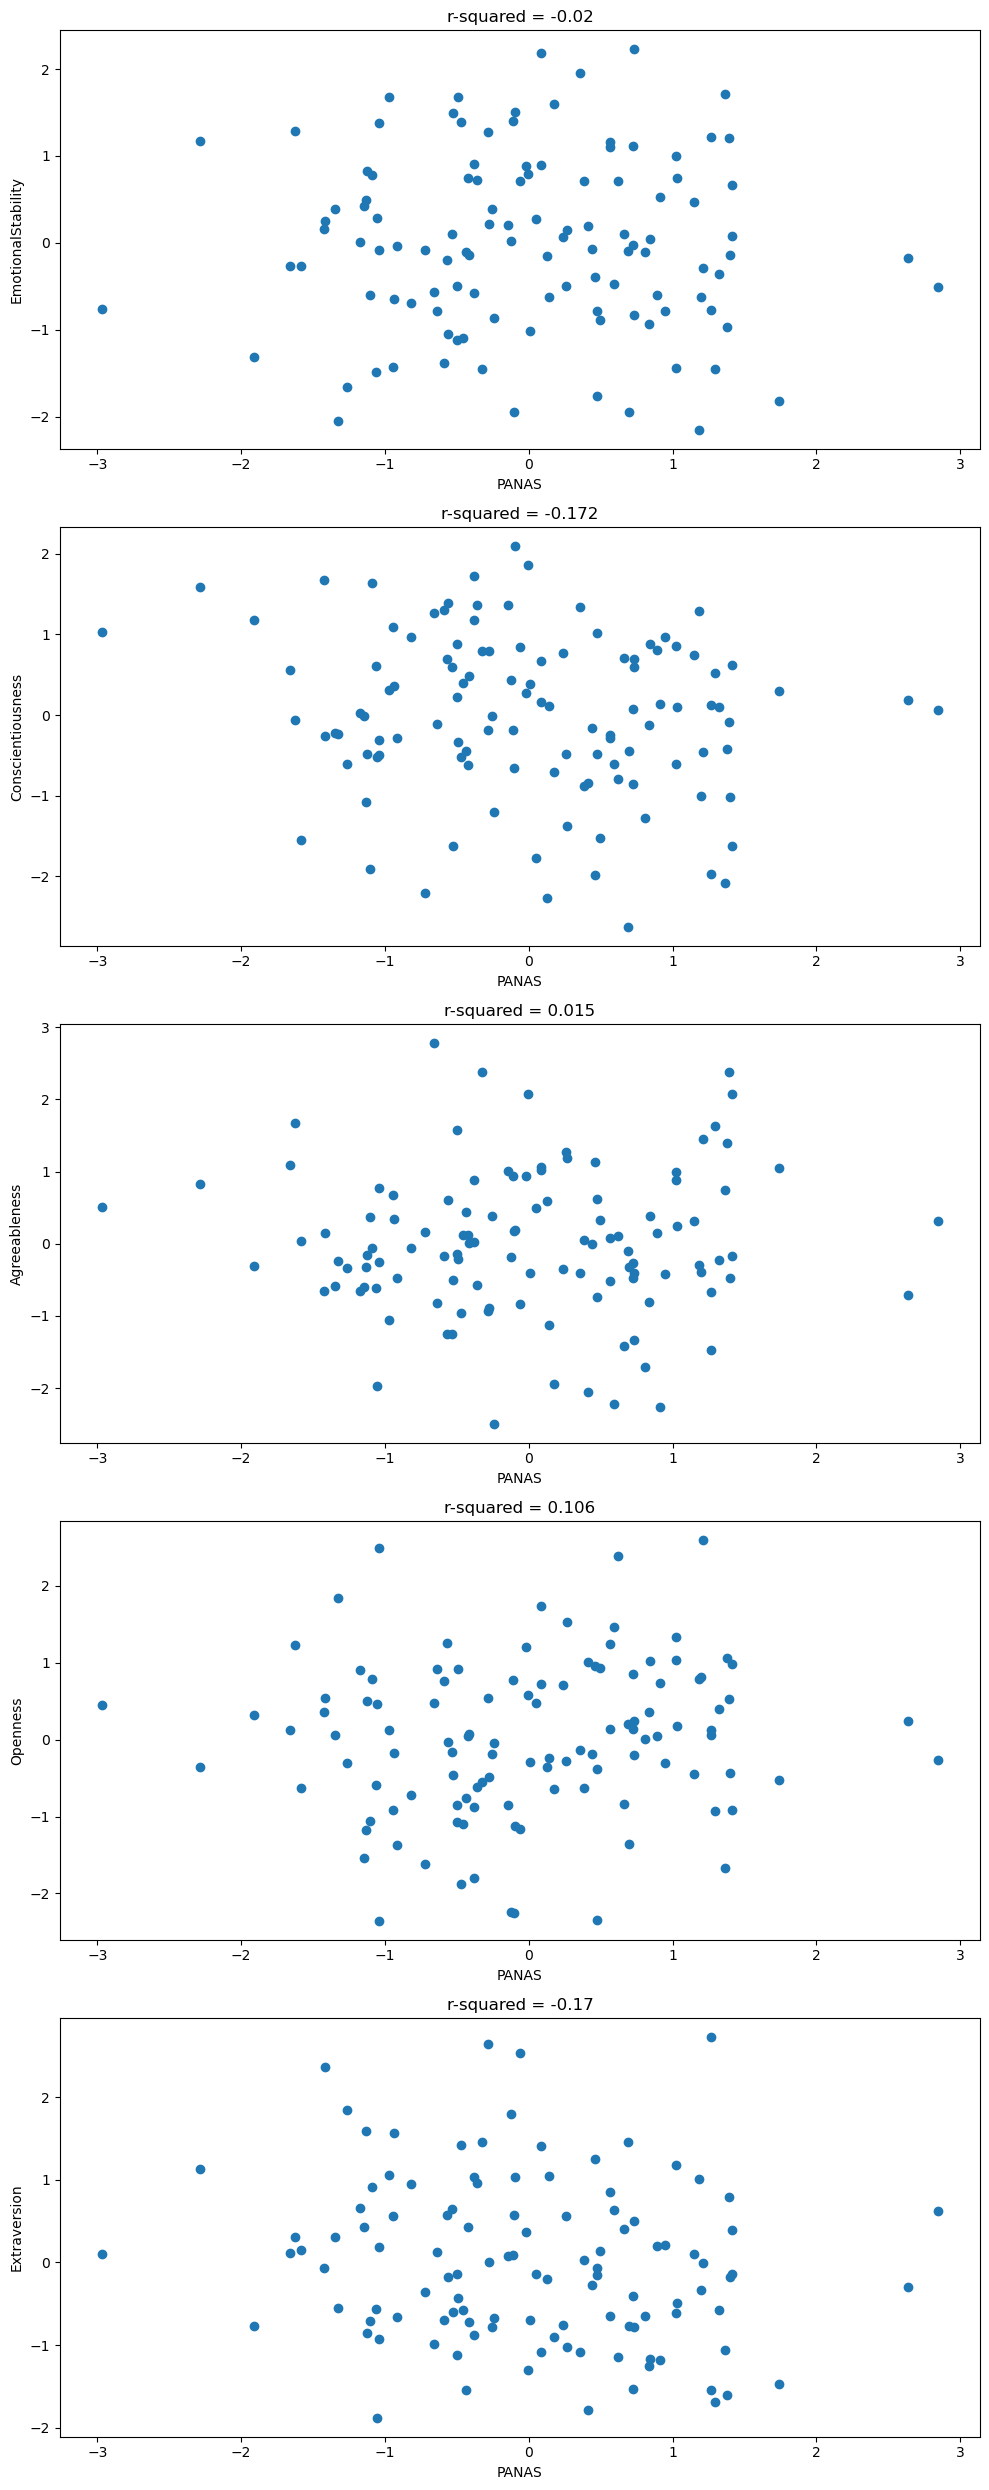

In [20]:
# step 4: correlation visualization
data1 = data.iloc[:, 1:] # data1 for visualization
scale = normScaler()  # for correlation
data1.iloc[:, :] = scale.fit_transform(data1.iloc[:, :].values)

def plot1(panas, target, data):
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (10, 25))
    
    for i in range(ax.shape[0]):
        r_panas = data.loc[:, [panas[0], target[i]]].corr()
        r_panas = r_panas.iloc[1,0]
        ax[i].scatter(data.loc[:, panas[0]], data.loc[:, target[i]])
        ax[i].set_title(f"r-squared = {round(r_panas, 3)}",loc="center")
        ax[i].set_xlabel(panas[0])
        ax[i].set_ylabel(target[i])
                         
    fig.tight_layout()
    
    return fig, ax

target = recCrit_PANAS[1:]
fig, ax = plot1(recCrit_PANAS, target, data1)

plt.show()


In [12]:
# step 5: data transformation for recommendation
data2 = data.copy() # data2 for recommendation
scaler2 = uniformScaler()
data2.iloc[:, 1:] = scaler2.fit_transform(data.iloc[:, 1:].values)
df_surprise = toSurprise(data2.loc[:, ["pPlace",targets[id]]], targets[id])
df_surprise.columns = ["randID", "itemID", "rating"]

# step 6: training, test separation
rateTest = 0.4
print(f"Training sample: {data.shape[0] - int(data.shape[0]*rateTest)} \n Testing sample: {int(data.shape[0]*rateTest)}")

trainNo = data.shape[0] - int(data.shape[0]*rateTest)
testNo = int(data.shape[0]*rateTest)

dfTr_ground = data2.iloc[:trainNo,:]
dfTr_ground = dfTr_ground.loc[:, recCrit_PANAS]
dfTs_ground = data2.iloc[trainNo:, :]
dfTs_ground = dfTs_ground.loc[:, recCrit_PANAS]
dfTr_surprise = df_surprise[df_surprise['randID'] < (trainNo)] 
dfTs_surprise = df_surprise[df_surprise['randID'] >= (trainNo)]

Training sample: 68 
 Testing sample: 45


In [13]:
# step 6 recommendation modeling
# step 6.1: surprise model

np.random.seed(randSeed)

reader = Reader(line_format='user item rating', rating_scale=(0, 1)) # The surprise model is only for rating of positive numbers. One should use uniform scaler.
dataSurTr = Dataset.load_from_df(dfTr_surprise, reader) 
dataSurTs = Dataset.load_from_df(dfTs_surprise,reader)
setTs = dataSurTs.build_full_trainset()
setTs_surprise = setTs.build_testset() 
print(f"Check if setTs contains all test samples: {len(setTs_surprise)}")


param_grid = {"n_factors":np.arange(1, 68, 1).tolist(), # 68 is the sample size of the training set.
              "n_epochs": [5, 10], 
              "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6], 
              "random_state":[randSeed]} 
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(dataSurTr)
# best RMSE score
print(f"rmse score: {gs.best_score['rmse']}")
# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

# Grid search
algoSVD = gs.best_estimator["rmse"]
algoSVD.fit(setTs)
print(f"The shape of estimated hidden influencers by Surprise: {algoSVD.pu.shape}")


# predict
print(f"0 means: {setTs.to_raw_iid(0)}")
print(f"1 means: {setTs.to_raw_iid(1)}")
      
# category prediction
pred_park = []
pred_mall = []
j = 0
for i in range(len(setTs.all_users())):
    uid = setTs.to_raw_uid(i)
    pred_park.append(algoSVD.predict(uid, setTs.to_raw_iid(0), r_ui=0.1, verbose=False))
    pred_mall.append(algoSVD.predict(uid, setTs.to_raw_iid(1), r_ui=0.1, verbose=False))
    if pred_park[i].est <= pred_mall[i].est:
        j = j + 1
print(f"The number of preferring mall: {str(j)}")


Check if setTs contains all test samples: 45
rmse score: 0.18187938728836955
{'n_factors': 54, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4, 'random_state': 42}
The shape of estimated hidden influencers by Surprise: (45, 54)
0 means: mall
1 means: park
The number of preferring mall: 32


In [14]:
# step 6.2: ground model
np.random.seed(randSeed)

# SVD result is positively correlated to conscientiousness in step 8

modGrd = GMRec(n_components=2, random_state=randSeed).fit(dfTr_ground.loc[:, ['PANAS', 'Conscientiousness']])
print(f"Ground algorithm converged? {modGrd.converged_}")
if modGrd.converged_: 
    # dfTs_ground_ = normer.transform(dfTs_ground)
    outputGrd = modGrd.predict(dfTs_ground.loc[:, ['PANAS', 'Conscientiousness']]) 
else: 
    outputGrd = np.nan

outputGrd = pd.DataFrame(outputGrd, columns=["gInter"], index=dfTs_ground.index)
outputGrd["randInter"] = data2.loc[trainNo:, "pPlace"].apply(lambda x: 0.5 if x == "park" else -0.5)
outputGrd = pd.concat([dfTs_ground, outputGrd], axis=1)
temp = outputGrd.corr()
print("Before recoding the ground algorithm, the correlations among variables: \n")
print(temp.iloc[-1,:].to_dict())
print("\n")
outputGrd["groundInter"] = outputGrd["gInter"].apply(lambda x: 0.5 if x == 1 else -0.5) # 1 or 0 depends on corr with randInter which should be positive.
temp = outputGrd.corr()
print("After recoding the ground algorithm, the correlations among variables: \n ") # The correlation between "groundInter" and "randInter" should be positive.
print(temp.iloc[-1,:].to_dict())

Ground algorithm converged? False
Before recoding the ground algorithm, the correlations among variables: 

{'PANAS': 0.47230611726255345, 'EmotionalStability': 0.14435031492783146, 'Conscientiousness': 0.21099519143807757, 'Agreeableness': 0.03293425590602604, 'Openness': 0.39832294295142623, 'Extraversion': -0.22275313379257936, 'gInter': nan, 'randInter': 1.0}


After recoding the ground algorithm, the correlations among variables: 
 
{'PANAS': nan, 'EmotionalStability': nan, 'Conscientiousness': nan, 'Agreeableness': nan, 'Openness': nan, 'Extraversion': nan, 'gInter': nan, 'randInter': nan, 'groundInter': nan}


/opt/conda/envs/jupyter/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [15]:
# Step 7, PAI calculation on the test set.

np.random.seed(randSeed)

randInter = ['PANAS','EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'Extraversion'] + ['randInter']
AIInter = ['PANAS','EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'Extraversion'] + ['SVDInter']
groundInter = ['PANAS','EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'Extraversion'] + ['groundInter']

predPark = [x.est for x in pred_park]
predMall = [x.est for x in pred_mall]
parkMall = ["park" if x >= y else "mall" for x, y in zip(predPark, predMall)]
parkMall = pd.DataFrame(parkMall, columns=["predAI"], index=dfTs_ground.index)
dataPAI = pd.concat([dfTs_ground, parkMall.copy(), dfTs_surprise["itemID"]], axis=1)
dataPAI["SVDInter"] = dataPAI["predAI"].apply(lambda x: 0.5 if x == "park" else -0.5)
dataPAI["randInter"] = dataPAI["itemID"].apply(lambda x: 0.5 if x == "park" else -0.5)
dataPAI["groundInter"] = outputGrd["groundInter"]
corrMat = dataPAI.loc[:, randInter].corr()
print(corrMat.iloc[-1,:])
print("\n")
corrMat1 = dataPAI.loc[:, groundInter].corr()
print(corrMat1.iloc[-1,:])
print("\n")
corrMat2 = dataPAI.loc[:, AIInter].corr()
print(corrMat2.iloc[-1,:]) # The Agreeableness correlates to the SVDInter recommendation. This is for step 6.2.

# print(dataPAI.head())
dataPAI_ = dataPAI.copy()

PANAS                 0.472306
EmotionalStability    0.144350
Conscientiousness     0.210995
Agreeableness         0.032934
Openness              0.398323
Extraversion         -0.222753
randInter             1.000000
Name: randInter, dtype: float64


PANAS                NaN
EmotionalStability   NaN
Conscientiousness    NaN
Agreeableness        NaN
Openness             NaN
Extraversion         NaN
groundInter          NaN
Name: groundInter, dtype: float64


PANAS                -0.049736
EmotionalStability   -0.136267
Conscientiousness    -0.373229
Agreeableness        -0.179534
Openness             -0.141340
Extraversion          0.121414
SVDInter              1.000000
Name: SVDInter, dtype: float64


In [16]:
# Step 8.1 PAI calculation needs the training of a regression model.

np.random.seed(randSeed)

dataPAI = dataPAI_.copy()
randIterCol = dataPAI["randInter"]
target = ['PANAS']
targetID = 0
interTar = ['SVDInter', 'groundInter']
interTarID = 0
resultPAI = {interTar[0]:[], interTar[1]:[]}
data3 = data.copy()
dataPAI = pd.concat([data3.loc[:, recCrit_PANAS], dataPAI.loc[:, interTar]], axis=1)
dataPAI = dataPAI.iloc[trainNo:, :]

for interTarID in range(len(interTar)): 
    inter = [target[targetID],'EmotionalStability', 'Conscientiousness', 'Agreeableness', 'Openness', 'Extraversion', interTar[interTarID]]
    dataRandInterV = pd.DataFrame(np.multiply(dataPAI.loc[:, randInter[2]].values,\
                                         dataPAI.loc[:, inter[-1]].values),columns=["interaction"], index=dfTs_ground.index)
    dataRandInterV = pd.concat([dataPAI.loc[:, inter], dataRandInterV], axis=1)
    inter = inter + ["interaction"]
    
    # Train
    nums = np.arange(trainNo,trainNo + dataPAI.shape[0],1)
    recPAI = {"ori":[],"nonInter":[], "Fact":[], "CFact":[]} 
    PAI = np.zeros([dataRandInterV.shape[0], 5])
    PAI = pd.DataFrame(PAI, columns=[list(recPAI.keys())+ ['PAI']], index=dfTs_ground.index)
    
    for num in nums:
        
        # data initialize
        testSet = dataRandInterV.loc[num, inter].values
        trainSet = dataRandInterV.drop([num], axis=0)
    
        # Change value according to PAI
        recPAI = {"ori":[testSet],"nonInter":[], "Fact":[], "CFact":[]} 
        # NonInter
        temp = testSet.copy()
        temp[6:] = 0 # treatment, interaction
        recPAI["nonInter"] = [temp]
        # Fact
        temp = testSet.copy()
        temp[1:-2] = 0 # set all BF other than treatments to 0
        recPAI["Fact"] = [temp]
        # CFact
        temp = testSet.copy()
        if testSet[-2] == 0.5: temp[-2] = -0.5
        if testSet[-2] == -0.5: temp[-2] = 0.5
        temp[-1] = temp[-2] * temp[2] # conscientiousness
        temp[1:-2] = 0
        recPAI["CFact"] = [temp]
    
        # Training
        # normalize
        normer = normScaler().fit(trainSet.values)
        trainSetNorm = normer.transform(trainSet.values)
        trainSetNorm = pd.DataFrame(trainSetNorm, columns = inter)
        model = LinearSVR(random_state=randSeed, max_iter=10000).fit(trainSetNorm.loc[:,inter[1:]].values, \
                              trainSetNorm.loc[:,inter[0]])
        for key in recPAI.keys():
            recPAI[key].append(normer.transform(recPAI[key][0].reshape(-1,1).T))
            temp = model.predict(recPAI[key][1][0,1:].reshape(-1,1).T)
            recPAI[key].append(temp)
            PAI.loc[num, key] = temp
        
    # PAI cal
    temp1 = np.add(PAI.loc[:, 'Fact'].values, PAI.loc[:, 'nonInter'].values) ** 2
    temp2 = np.add(PAI.loc[:, 'CFact'].values, PAI.loc[:, 'nonInter'].values) ** 2
    PAI.loc[:, 'PAI'] = temp1 - temp2
    resultPAI[interTar[interTarID]] = PAI
    
for key in resultPAI.keys():
    resultPAI[key]["inter"] = dataPAI[key]
    resultPAI[key]["randInter"] = randIterCol
print("Training ends!")

Training ends!


In [17]:
# 8.2 Transform PAI < -3 and > 3 (disabled) and transform the PAI value to the Optimum and Inoptimum codings
resultPAI_nonExtr = resultPAI.copy()
if False:
    temp1 = (resultPAI["SVDInter"]["PAI"] >= 3) | (resultPAI["SVDInter"]["PAI"] <= -3)
    temp2 = (resultPAI["groundInter"]["PAI"] >= 3) | (resultPAI["groundInter"]["PAI"] <= -3)
    resultPAI_nonExtr["SVDInter"] = resultPAI["SVDInter"].loc[temp1.iloc[:,0], :]
    resultPAI_nonExtr["groundInter"] = resultPAI["groundInter"].loc[temp2.iloc[:,0], :]
resultPAI_nonExtr["SVDInter"]["PAIInter"] = resultPAI_nonExtr["SVDInter"].apply(lambda x: 0.5 if x["PAI"] >= 0 else -0.5, axis=1)
resultPAI_nonExtr["groundInter"]["PAIInter"] = resultPAI_nonExtr["groundInter"].apply(lambda x: 0.5 if x["PAI"] >= 0 else -0.5, axis=1)

resultPAI_nonExtr["SVDInter"]["opt"] = resultPAI_nonExtr["SVDInter"].apply(lambda x: 1 if x["PAIInter"] == x["randInter"] else 0, axis=1)
resultPAI_nonExtr["groundInter"]["opt"] = resultPAI_nonExtr["groundInter"].apply(lambda x: 1 if x["PAIInter"] == x["randInter"] else 0, axis=1)

# reorganize the data: 'opt': PAI, 'inopt': PAI
temp = resultPAI_nonExtr["SVDInter"]['opt'] == 1
temp1 = resultPAI_nonExtr["SVDInter"].loc[temp.iloc[:,0], 'PAI']
temp = resultPAI_nonExtr["SVDInter"]['opt'] != 1
temp2 = resultPAI_nonExtr["SVDInter"].loc[temp.iloc[:,0], 'PAI']
resultPAI_nonExtr["SVDInter_plot"] = pd.concat([temp1.reset_index(drop=True), temp2.reset_index(drop=True)], axis=1)
resultPAI_nonExtr["SVDInter_plot"].columns = ['opt', 'inopt']
temp = resultPAI_nonExtr["SVDInter"]['opt'] == 1
temp1 = resultPAI_nonExtr["groundInter"].loc[temp.iloc[:,0], 'PAI']
temp = resultPAI_nonExtr["SVDInter"]['opt'] != 1
temp2 = resultPAI_nonExtr["groundInter"].loc[temp.iloc[:,0], 'PAI']
resultPAI_nonExtr["groundInter_plot"] = pd.concat([temp1.reset_index(drop=True), temp2.reset_index(drop=True)], axis=1)
resultPAI_nonExtr["groundInter_plot"].columns = ['opt', 'inopt']

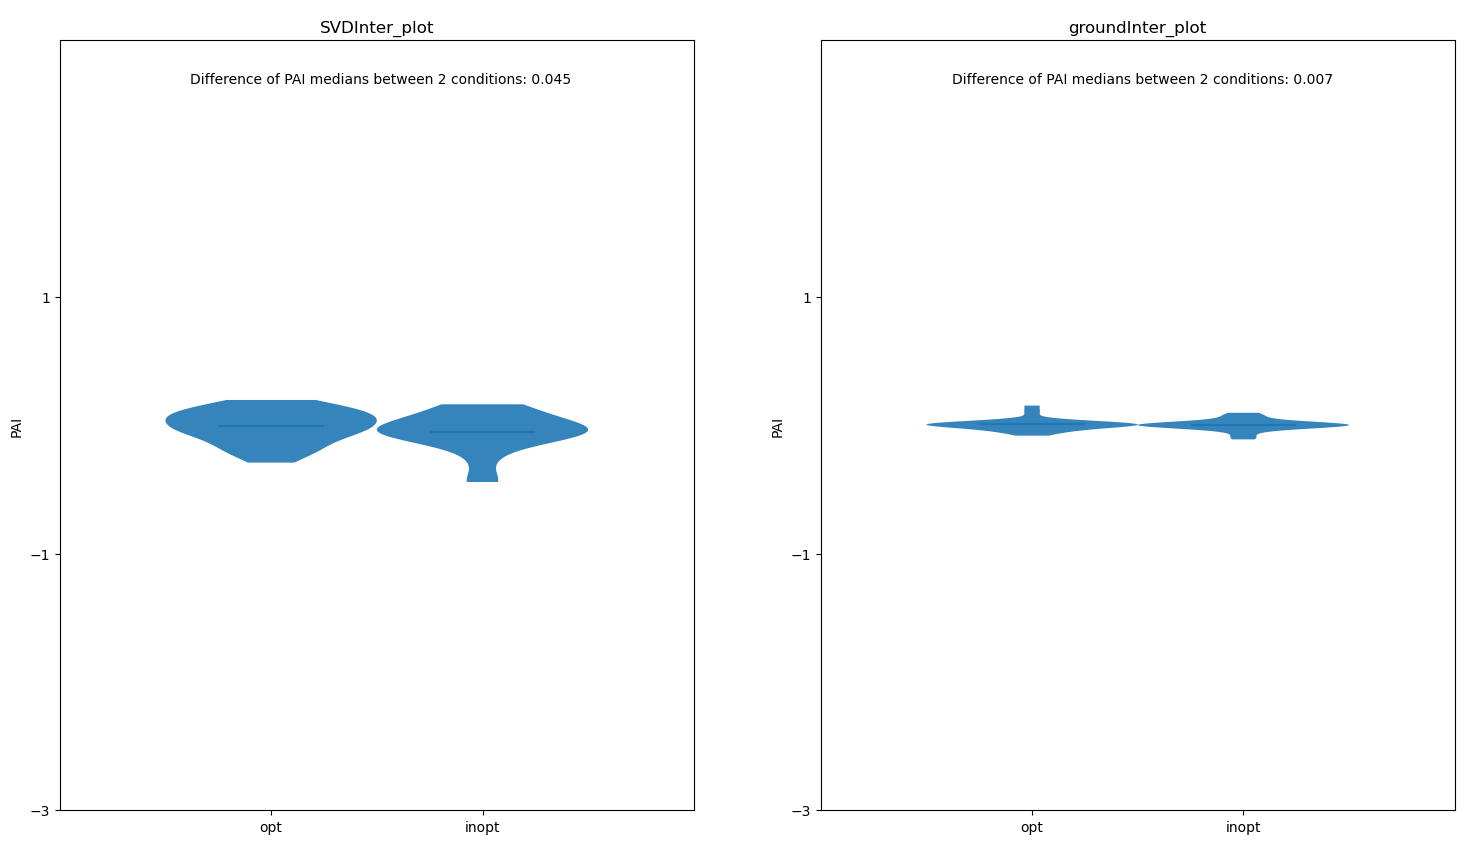

In [19]:
# 8.3 FINAL: Vis the difference of PAI value between optimum & inoptimum conditions. The larger the better.

resultPAI = resultPAI_nonExtr.copy()
toPlot = ["SVDInter_plot", "groundInter_plot"]

SVDInter_plot_diff = np.abs(np.nanmedian(resultPAI["SVDInter_plot"]['opt'].values) - np.nanmedian(resultPAI["SVDInter_plot"]['inopt'].values))
SVDInter_plot_diff = round(SVDInter_plot_diff, 3)
groundInter_plot_diff = np.abs(np.nanmedian(resultPAI["groundInter_plot"]['opt'].values) - np.nanmedian(resultPAI["groundInter_plot"]['inopt'].values))
groundInter_plot_diff = round(groundInter_plot_diff, 3)
median_diff = [SVDInter_plot_diff, groundInter_plot_diff]

i = -1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18, 10))
cord = (0.13, 0.9, 0.65, 0.9)
lim_y = (-2,2)
for key in toPlot:
    dataVis = {"opt":resultPAI[key]['opt'].values,
              'inopt':resultPAI[key]['inopt'].values}
    
    # Use np.nan to equalize the number of samples to violin plot. Then use median to replace np.nan.
    maxsize = max([a.size for a in dataVis.values()])
    data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in dataVis.items()}
    dfVis = pd.DataFrame(data_pad)
    dfVis['opt'] = dfVis['opt'].fillna(np.nanmean(dataVis["opt"]))
    dfVis['inopt'] = dfVis['inopt'].fillna(np.nanmean(dataVis["inopt"]))

    # Use violinplot:
    i += 1
    vp = ax[i].violinplot(dfVis, [1, 2], widths=1,
                   showmeans=False, showmedians=True, showextrema=False)
    # styling:
    for body in vp['bodies']:
        body.set_alpha(0.9)
    ax[i].set(
        xlim=(0, 3),
        ylim=(lim_y[0], lim_y[1]), yticks=np.arange(lim_y[0], lim_y[1], 2))
    ax[i].set_xticks([1, 2,])
    ax[i].set_xticklabels(['opt', 'inopt'])
    ax[i].set_ylabel('PAI')
    ax[i].set_title(key)
    ax[i].annotate(f"Difference of PAI medians between 2 conditions: {round(median_diff[i],3)}", 
    (cord[2*i+0],cord[2*i+1]), xycoords='subfigure fraction')

plt.show()
